# Worst-case History Viewer

Visually inspect the stored histories from `run_full_experiment.py`. Select an experiment folder and dataset split, then walk through the saved `StepRecord`s exactly as in `debug_test.ipynb`.

## Usage Steps
1. Set `EXPERIMENT_NAME` to the folder name under `assets/` (e.g. `experiment_20250318_153000`).
2. Set `DATASET_NAME` to the dataset split (e.g. `dataset_v0`).
3. Optionally adjust `EXAMPLE_INDEX` to show a specific failure case directory.
4. Run all cells to render each step (prompts, masks, logits) and final score breakdown.

In [1]:
from pathlib import Path
import sys
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
SAM2_ROOT = PROJECT_ROOT.parent / "sam2"
if SAM2_ROOT.exists() and str(SAM2_ROOT) not in sys.path:
    sys.path.insert(0, str(SAM2_ROOT))
ASSETS_DIR = PROJECT_ROOT / "assets"

In [2]:
import sys

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
SAM2_ROOT = PROJECT_ROOT.parent / "sam2"
if SAM2_ROOT.exists() and str(SAM2_ROOT) not in sys.path:
    sys.path.insert(0, str(SAM2_ROOT))

from debug_tests.debug_test import MAIN_DIR, StepRecord, _load_constants
from image_processings.info import PromptBundle
from image_processings.image_pre_seg import image_i_segment, change_image_type
from configs.pipeline_config import load_pipeline_config
from datasets.dataset import load_dataset

import json
import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt


In [3]:
# Configuration -----------------------------------------------------------
EXPERIMENT_NAME = "experiment_20251008_181323"  # e.g. 'experiment_20250318_153000'
DATASET_NAME = "dataset_v0"                      # choose dataset folder inside experiment
EXAMPLE_INDEX = 2                                 # which example folder to visualise in worst_histories

experiment_path = ASSETS_DIR / EXPERIMENT_NAME
if not experiment_path.exists():
    raise FileNotFoundError(f"Experiment folder not found: {experiment_path}")

worst_dir = experiment_path / DATASET_NAME / "worst_histories"
if not worst_dir.exists():
    available = sorted([p.name for p in (experiment_path / DATASET_NAME).iterdir()]) if (experiment_path / DATASET_NAME).exists() else []
    raise FileNotFoundError(f"No worst_histories found under {worst_dir}. Available entries: {available}")

folders = sorted([p for p in worst_dir.iterdir() if p.is_dir()])
if not folders:
    raise RuntimeError(f"No example folders inside {worst_dir}")

EXAMPLE_INDEX = max(0, min(EXAMPLE_INDEX, len(folders) - 1))
example_folder = folders[EXAMPLE_INDEX]

metadata_path = example_folder / "history.json"
if not metadata_path.exists():
    raise FileNotFoundError(f"Missing history.json in {example_folder}")

metadata = json.loads(metadata_path.read_text(encoding="utf-8"))
mask_path = example_folder / "prediction.npz"
gt_path = example_folder / "ground_truth.npz"

pred_mask = np.load(mask_path)["mask"]
if pred_mask.ndim > 2:
    pred_mask = np.squeeze(pred_mask)
final_mask = pred_mask.astype(bool)

gt_mask = np.load(gt_path)["mask"]
if gt_mask.ndim > 2:
    gt_mask = np.squeeze(gt_mask)

gt_mask = gt_mask.astype(bool)
if gt_mask.shape != final_mask.shape:
    gt_mask = cv2.resize(gt_mask.astype(np.uint8), (final_mask.shape[1], final_mask.shape[0]), interpolation=cv2.INTER_NEAREST).astype(bool)

def _load_step_metadata(step_name: str) -> dict:
    for item in metadata.get("steps", []):
        if item.get("step") == step_name:
            return item
    return {}

step_dirs = sorted([p for p in example_folder.iterdir() if p.name.startswith("step_") and p.is_dir()])


In [4]:
def load_step(step_dir: Path) -> StepRecord:
    step_name = step_dir.name
    prompts_npz = np.load(step_dir / "prompts.npz")
    points = prompts_npz["points"]
    labels = prompts_npz["labels"]
    bundle = PromptBundle(points=points, labels=labels, mask_prompt=None, low_res_mask=None)

    logits = np.load(step_dir / "logits.npz")["logits"]
    mask = np.load(step_dir / "mask.npz")["mask"].astype(bool)
    positive_mask = np.load(step_dir / "positive_mask.npz")["mask"].astype(bool)

    meta = _load_step_metadata(step_name)
    iteration = int(meta.get("iteration", step_name.split("_")[-1]))
    stage = meta.get("stage", step_name)
    candidate_id = meta.get("candidate_id")

    return StepRecord(
        iteration=iteration,
        stage=stage,
        prompts=bundle,
        logits=logits,
        mask=mask,
        positive_mask=positive_mask,
        candidate_id=candidate_id,
    )

history = [load_step(step_dir) for step_dir in step_dirs]
print(f"Loaded {len(history)} steps from {example_folder.relative_to(experiment_path)}")


Loaded 4 steps from dataset_v0/worst_histories/013_1kg59aarb27s3bmibktht7vov


In [5]:
# Visualisation helpers ---------------------------------------------------
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

cached_vis_image = None
segments_np = None

segments_path = example_folder / "segments.npy"
if segments_path.exists():
    segments_np = np.load(segments_path)

image_path = example_folder / "image.npy"
if image_path.exists():
    cached_vis_image = np.load(image_path)

if cached_vis_image is None or segments_np is None:
    try:
        constants = _load_constants()
        pipeline_cfg = load_pipeline_config(MAIN_DIR / constants["pipeline_cfg"])

        images, dataset_masks, image_names = load_dataset(
            DATASET_NAME,
            data_root=None,
            target_long_edge=pipeline_cfg.dataset.target_long_edge,
            return_paths=True,
        )

        image_index = image_names.index(metadata["image_name"])
        raw_image = images[image_index]

        pre_cfg = pipeline_cfg.preprocessing
        slic_cfg = pre_cfg.slic
        pre_segment = image_i_segment(
            image=raw_image,
            new_size_of_image=pre_cfg.image_size,
            num_node_for_graph=pre_cfg.num_graph_nodes,
            compactness_in_SLIC=slic_cfg.compactness,
            sigma_in_SLIC=slic_cfg.sigma,
            min_size_factor_in_SLIC=slic_cfg.min_size_factor,
            max_size_factor_in_SLIC=slic_cfg.max_size_factor,
        )

        cached_vis_image = change_image_type(pre_segment.image_resized, "np.array")
        segment_tensor = pre_segment.segment_without_padding
        segments_np = segment_tensor.cpu().numpy() if hasattr(segment_tensor, "cpu") else np.array(segment_tensor)

        example_image_path = example_folder / "image.npy"
        example_segments_path = example_folder / "segments.npy"
        np.save(example_image_path, cached_vis_image)
        np.save(example_segments_path, segments_np)
    except Exception as exc:
        print(f"[Warn] Could not regenerate image/segments: {exc}")

if cached_vis_image is None:
    cached_vis_image = np.zeros((*final_mask.shape, 3), dtype=np.uint8)

if segments_np is not None and segments_np.shape != cached_vis_image.shape[:2]:
    segments_np = cv2.resize(
        segments_np.astype(np.int32),
        (cached_vis_image.shape[1], cached_vis_image.shape[0]),
        interpolation=cv2.INTER_NEAREST,
    )

if cached_vis_image.shape[:2] != final_mask.shape:
    cached_vis_image = cv2.resize(
        cached_vis_image,
        (final_mask.shape[1], final_mask.shape[0]),
        interpolation=cv2.INTER_LINEAR,
    )
    if segments_np is not None:
        segments_np = cv2.resize(
            segments_np.astype(np.int32),
            (final_mask.shape[1], final_mask.shape[0]),
            interpolation=cv2.INTER_NEAREST,
        )


def overlay_mask(image, mask, color=(0, 255, 0), alpha=0.45):
    base = image.astype(np.float32)
    mask_bool = np.asarray(mask, dtype=bool)
    base[mask_bool] = base[mask_bool] * (1 - alpha) + np.array(color, dtype=np.float32) * alpha
    return np.clip(base, 0, 255).astype(np.uint8)


def describe_step(step_idx, step, image, segments, gt_mask):
    mask_bool = np.asarray(step.mask, dtype=bool)
    pos_points = step.prompts.points[step.prompts.labels == 1]
    neg_points = step.prompts.points[step.prompts.labels == 0]

    compare = np.asarray(gt_mask, dtype=bool)
    inter = np.logical_and(mask_bool, compare).sum()
    union = np.logical_or(mask_bool, compare).sum()
    iou = float(inter / union) if union else 1.0
    denom = mask_bool.sum() + compare.sum()
    dice = float(2 * inter / denom) if denom else 1.0

    display(Markdown(
        f"**Step {step_idx}: {step.stage}** — candidate: `{step.candidate_id}` | IoU={iou:.3f}, Dice={dice:.3f}"
    ))

    if segments is not None:
        boundary_img = mark_boundaries(img_as_float(image), segments)
    else:
        boundary_img = image

    overlay = overlay_mask(image, mask_bool, (0, 220, 0), alpha=0.45)
    overlay = overlay_mask(overlay, np.logical_and(compare, ~mask_bool), (255, 0, 0), alpha=0.35)

    logits = np.array(step.logits)
    if logits.ndim == 3 and logits.shape[0] == 1:
        logits = logits[0]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].imshow(boundary_img)
    axes[0].set_title("SLIC & prompts")
    axes[0].axis('off')
    if pos_points.size > 0:
        axes[0].scatter(pos_points[:, 0], pos_points[:, 1], marker='*', s=140, c='lime', edgecolor='white', linewidth=1.2)
    if neg_points.size > 0:
        axes[0].scatter(neg_points[:, 0], neg_points[:, 1], marker='*', s=140, c='red', edgecolor='white', linewidth=1.2)

    axes[1].imshow(overlay)
    axes[1].set_title("Mask overlay")
    axes[1].axis('off')

    im = axes[2].imshow(logits, cmap='coolwarm')
    axes[2].set_title("Logits")
    axes[2].axis('off')
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    plt.tight_layout()


Y_pred = cached_vis_image  # alias kept for notebooks referencing earlier variable name

display(Markdown(f"**Loaded example:** `{example_folder.name}` — image `{metadata['image_name']}`"))
display(Markdown(f"Image shape: {cached_vis_image.shape} | Final mask shape: {final_mask.shape}"))


**Loaded example:** `013_1kg59aarb27s3bmibktht7vov` — image `1kg59aarb27s3bmibktht7vov.png`

Image shape: (260, 246, 3) | Final mask shape: (260, 246)

**Step 0: initial** — candidate: `None` | IoU=0.509, Dice=0.675

**Step 1: promotion** — candidate: `22` | IoU=0.793, Dice=0.885

**Step 2: refine** — candidate: `None` | IoU=0.842, Dice=0.914

**Step 3: selection** — candidate: `None` | IoU=0.509, Dice=0.675

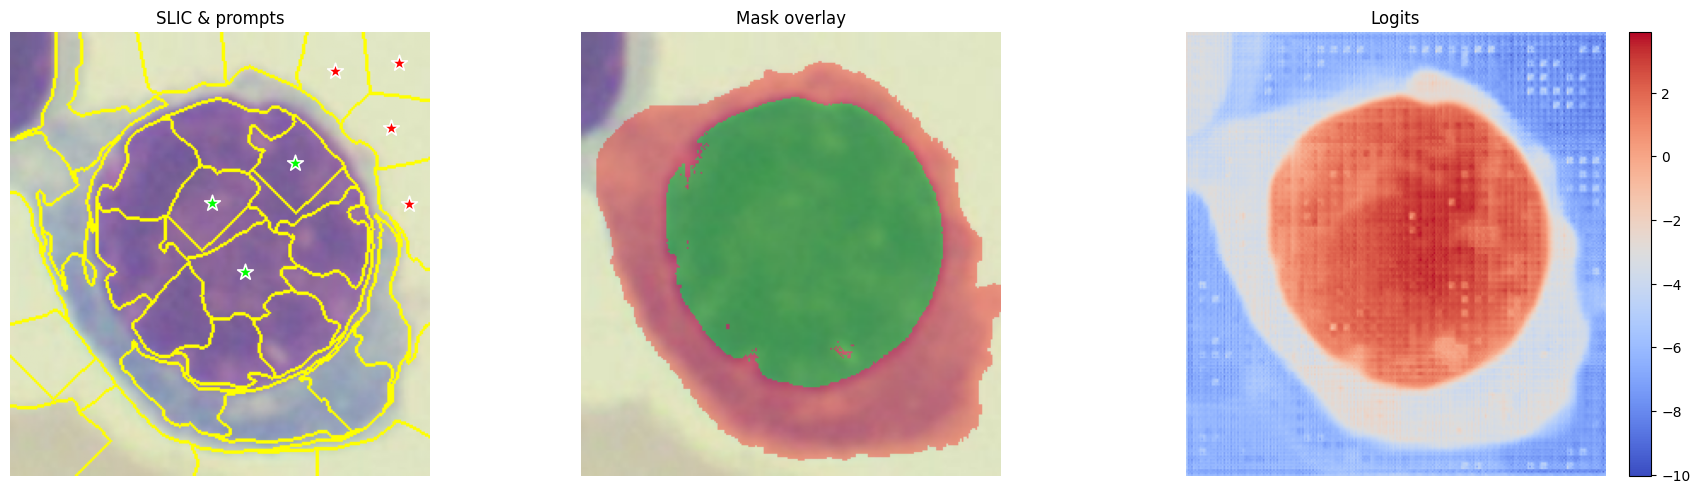

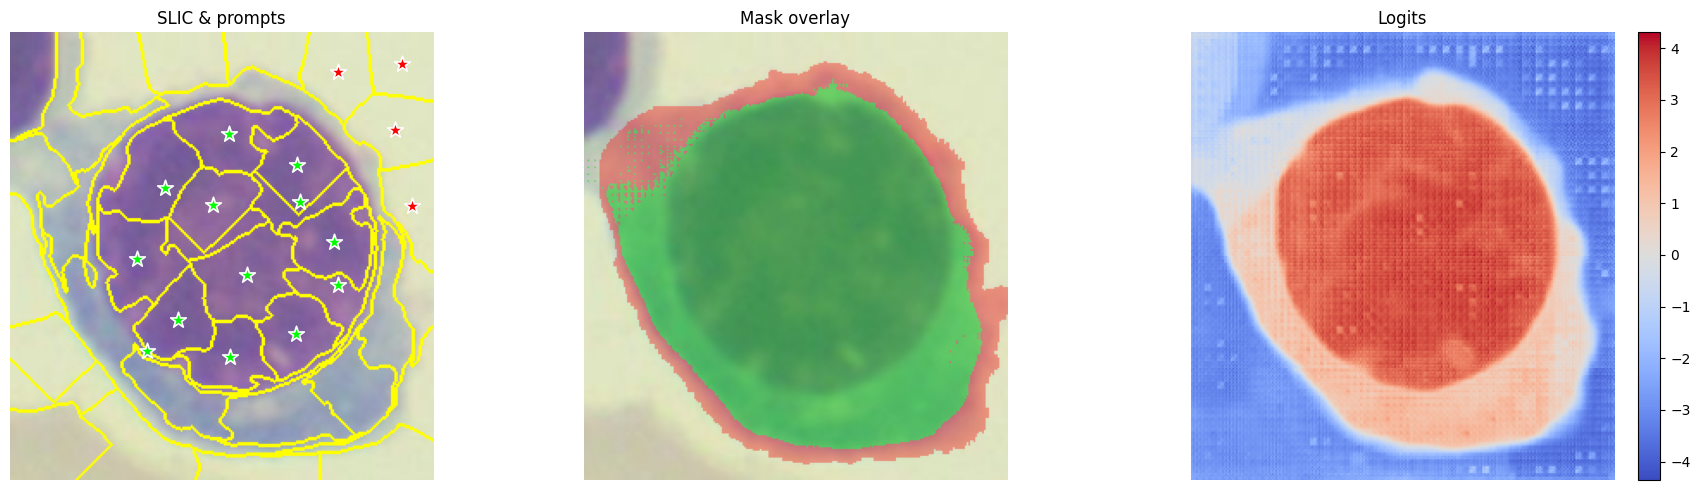

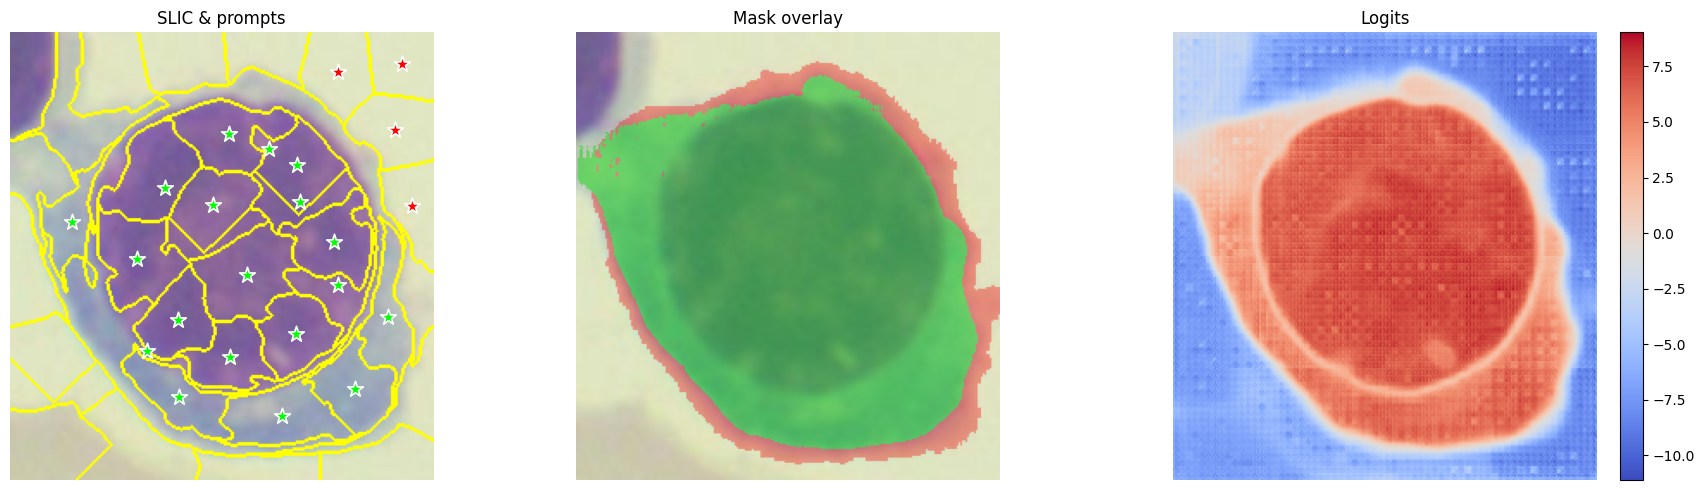

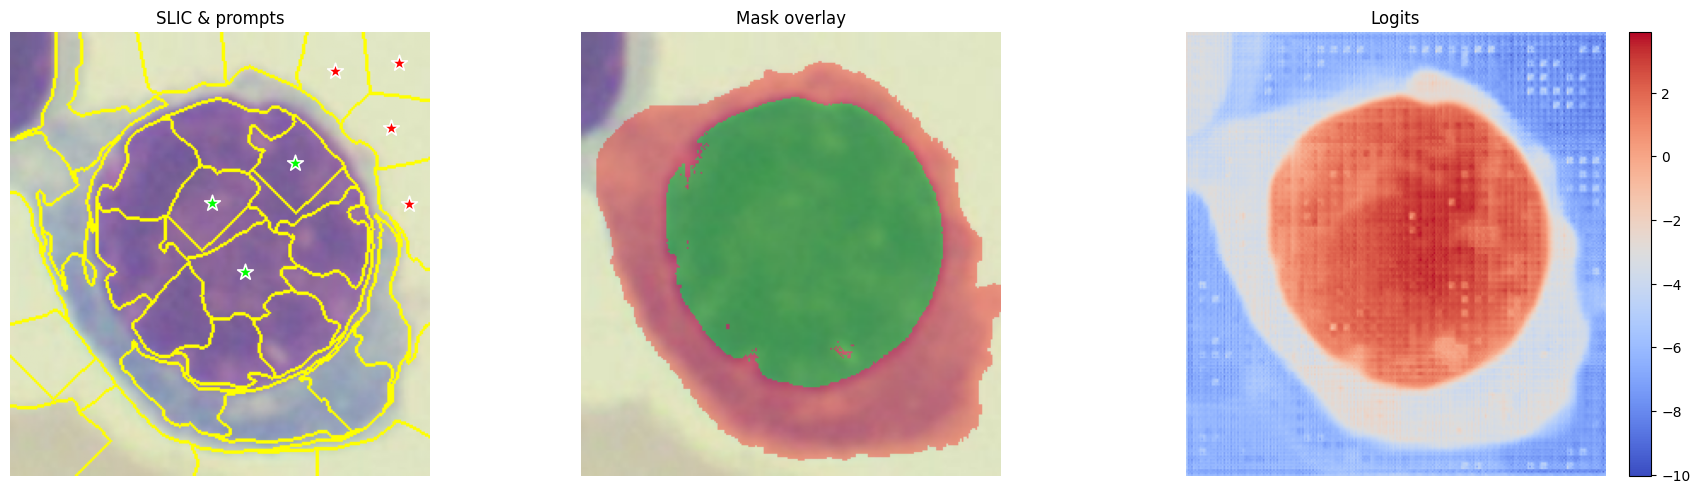

In [6]:
# Render steps ------------------------------------------------------------
for idx, step in enumerate(history):
    describe_step(idx, step, cached_vis_image, segments_np, gt_mask)

In [7]:
# Score breakdown ---------------------------------------------------------
pool_stats = metadata.get("pool_stats")
score_details = metadata.get("scored_details")

if score_details:
    try:
        import pandas as pd
        df = pd.DataFrame(score_details)
        display(Markdown("**Mask pool scoring (normalised components):**"))
        display(df)
    except Exception:
        print(score_details)
else:
    print("No score_details stored in metadata.")

if pool_stats:
    display(Markdown("**Pool stats:**"))
    for key, value in pool_stats.items():
        if isinstance(value, dict):
            display(Markdown(f"- `{key}`: {value}"))
        else:
            display(Markdown(f"- `{key}` = {value}"))


No score_details stored in metadata.


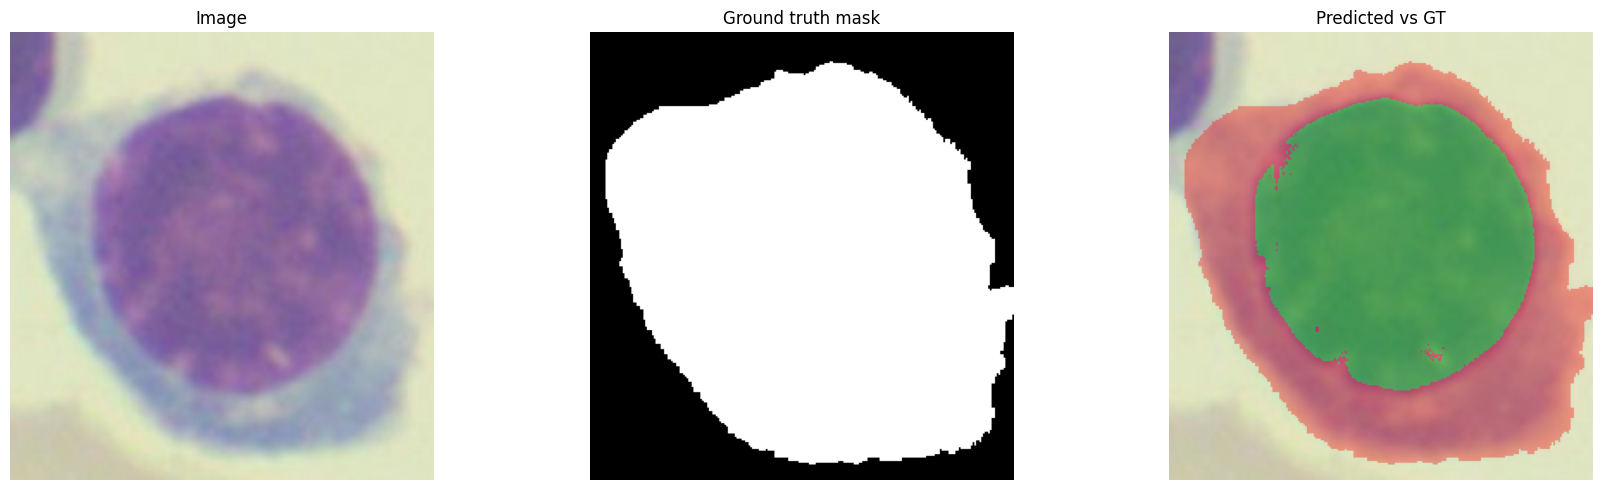

In [8]:
# Final overlay -----------------------------------------------------------
final_overlay = overlay_mask(cached_vis_image, final_mask, (0, 220, 0), alpha=0.45)
final_overlay = overlay_mask(final_overlay, np.logical_and(gt_mask, ~final_mask), (255, 0, 0), alpha=0.35)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(cached_vis_image)
axes[0].set_title("Image")
axes[0].axis('off')

axes[1].imshow(gt_mask, cmap='gray')
axes[1].set_title("Ground truth mask")
axes[1].axis('off')

axes[2].imshow(final_overlay)
axes[2].set_title("Predicted vs GT")
axes[2].axis('off')
plt.tight_layout()
